# Processing the Dataset

In [60]:
# # run only to verify the dataset read op
# import numpy as np
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/intel-image-classification'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [208]:
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.15.0


In [54]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [55]:
data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_data_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"

num_classes = 6
img_width = 150
img_height = 150
batch_size = 64
seed = 1

In [56]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [57]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [58]:
val_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [129]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    seed=seed,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 3000 images belonging to 6 classes.


In [130]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

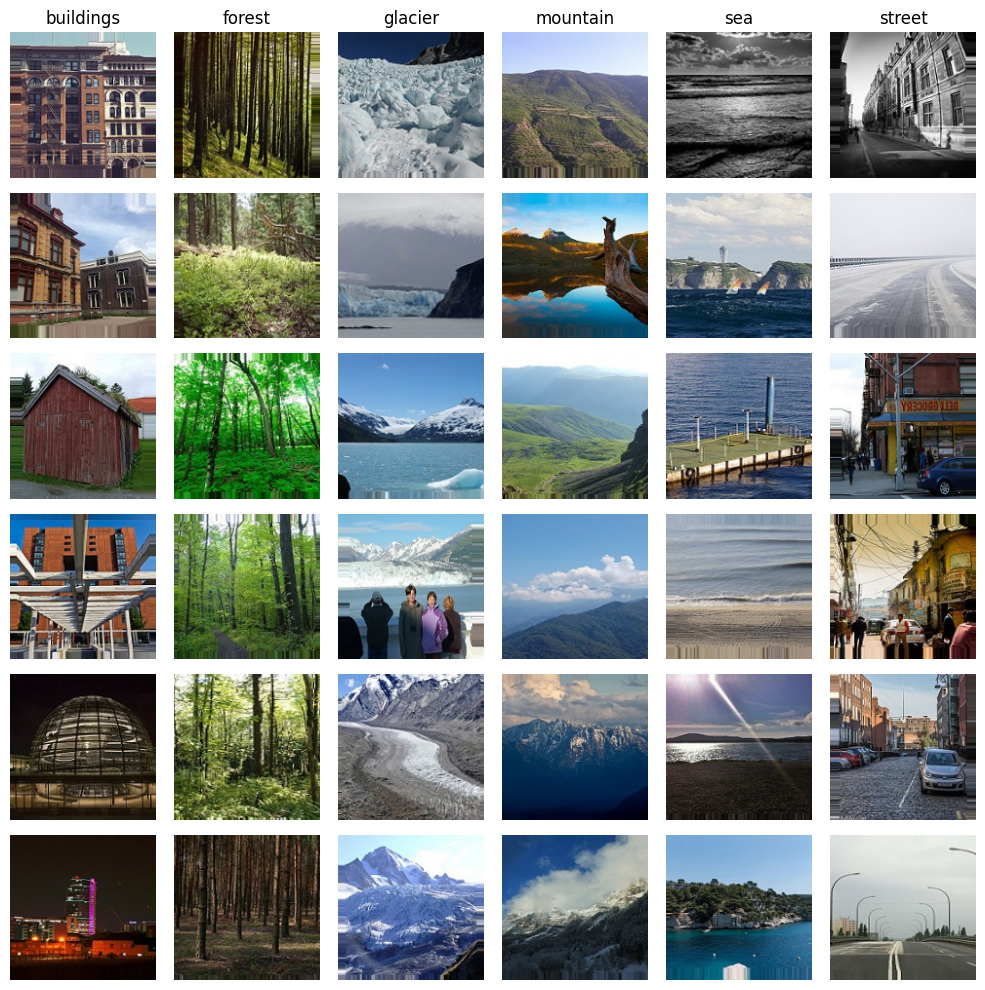

In [61]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(6, 6, figsize=(10, 10))

for i, class_label in enumerate(class_labels):
    images, _ = next(iter(train_generator))
    
    # Get indices of images belonging to the current class
    class_indices = np.where(np.argmax(_, axis=1) == i)[0]
    
    # Get random indices for selecting 6 images
    random_indices = np.random.choice(class_indices, 6, replace=False)
    
    for j, index in enumerate(random_indices):
        # Display the j-th randomly selected image of the current class in the corresponding subplot
        ax = axes[j, i]
        ax.imshow(images[index])
        ax.axis('off')
        if j == 0:
            ax.set_title(class_label)

plt.tight_layout()
plt.show()

# Commonly used function definitions

In [63]:
def plot_learning_curve(history_):
    training_loss = history_.history['loss']
    validation_loss = history_.history['val_loss']
    training_accuracy = history_.history['accuracy']
    validation_accuracy = history_.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [64]:
def evaluate_on_test_dataset(model_):
    test_loss, test_accuracy = model_.evaluate(test_generator)
    print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

In [157]:
# this test set is to find the worst classified example (without having to use the test_generator)
test_set = list()
for i in range(47):
    x_, y_ = test_generator[i]
    test_set.extend(zip(x_, y_))

In [194]:
def plot_worst_classified_examples(preds):    
    # Find misclassified examples
    worst_misclassifications = dict()
    for i, (x, y_true) in enumerate(test_set):
        pred_label = np.argmax(preds[i])
        true_label = np.argmax(y_true)
        if pred_label != true_label:
            prob_diff = preds[i][pred_label] - preds[i][true_label]
            if true_label not in worst_misclassifications:
                worst_misclassifications[true_label] = (x, prob_diff, pred_label)
            else:
                if worst_misclassifications[true_label][1] < prob_diff:
                    worst_misclassifications[true_label] = (x, prob_diff, pred_label)

#     # prints images 1 by 1
#     for key, value in worst_misclassifications.items():
#         true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
#         pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[1])
#         plt.imshow(value[0])
#         plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
#         plt.axis('off')
#         plt.show()
    
    # prints images as subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    for idx, (key, value) in enumerate(worst_misclassifications.items()):
        true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
        pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[2])
        
        r, c = (0, idx) if idx <= 2 else (1, idx-3)
        axs[r, c].imshow(value[0])
        axs[r, c].set_title(f"True: {true_lbl}, Pred: {pred_lbl}")
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# 1. Fine-tune ResNet50

In [197]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)

In [198]:
x = base_model.output
x = GlobalAvgPool2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [199]:
model = Model(inputs=base_model.input, outputs=predictions)

In [200]:
for layer in base_model.layers:
    layer.trainable = False

In [201]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [202]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [203]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
  1/176 ━━━━━━━━━━━━━━━━━━━━ 38:06 13s/step - accuracy: 0.1562 - loss: 1.9437

W0000 00:00:1712606071.150459      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/176 ━━━━━━━━━━━━━━━━━━━━ 1:01 424ms/step - accuracy: 0.1829 - loss: 1.8855

W0000 00:00:1712606083.812500      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.2890 - loss: 1.6814

W0000 00:00:1712606137.578806      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 96s 473ms/step - accuracy: 0.2894 - loss: 1.6805 - val_accuracy: 0.4768 - val_loss: 1.3127
Epoch 2/30


W0000 00:00:1712606153.851279      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 431ms/step - accuracy: 0.4900 - loss: 1.2720 - val_accuracy: 0.5685 - val_loss: 1.1382
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 430ms/step - accuracy: 0.5444 - loss: 1.1411 - val_accuracy: 0.5428 - val_loss: 1.1235
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 430ms/step - accuracy: 0.5679 - loss: 1.0752 - val_accuracy: 0.5781 - val_loss: 1.0370
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 427ms/step - accuracy: 0.5828 - loss: 1.0334 - val_accuracy: 0.5977 - val_loss: 1.0093
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 430ms/step - accuracy: 0.5939 - loss: 1.0114 - val_accuracy: 0.5870 - val_loss: 1.0328
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 434ms/step - accuracy: 0.6095 - loss: 0.9838 - val_accuracy: 0.5845 - val_loss: 0.9714
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 429ms/step - accuracy: 0.6049 - loss: 0.9746 - val_accuracy: 0.5421 - val_loss: 1.0642
Epoch 9/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 430ms/step - accuracy: 0.6164 - loss: 0.9733 - val

In [204]:
evaluate_on_test_dataset(model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 390ms/step - accuracy: 0.6449 - loss: 0.8956
Test Loss: 0.8909378051757812
Test Accuracy: 0.6653333306312561


W0000 00:00:1712608443.503477      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


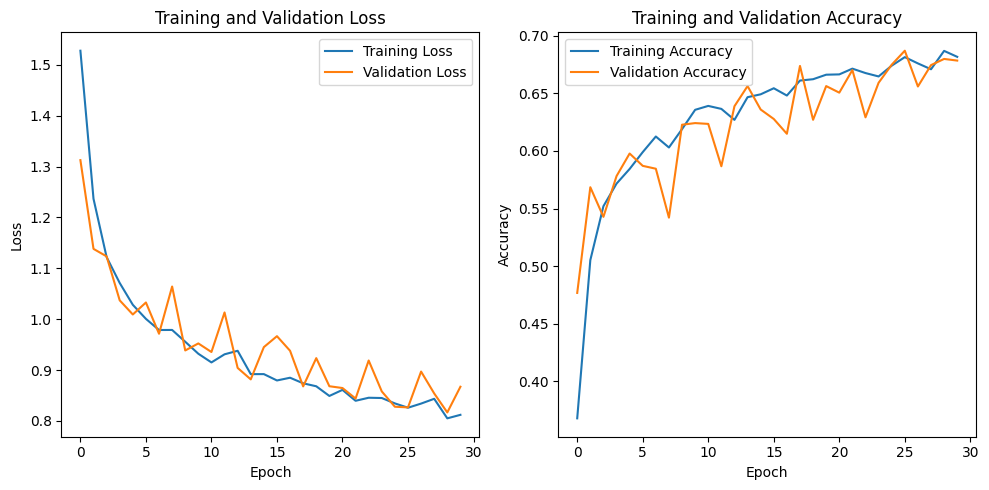

In [205]:
plot_learning_curve(history)

In [206]:
predictions = model.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step

W0000 00:00:1712608448.607590      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step


W0000 00:00:1712608467.906906      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


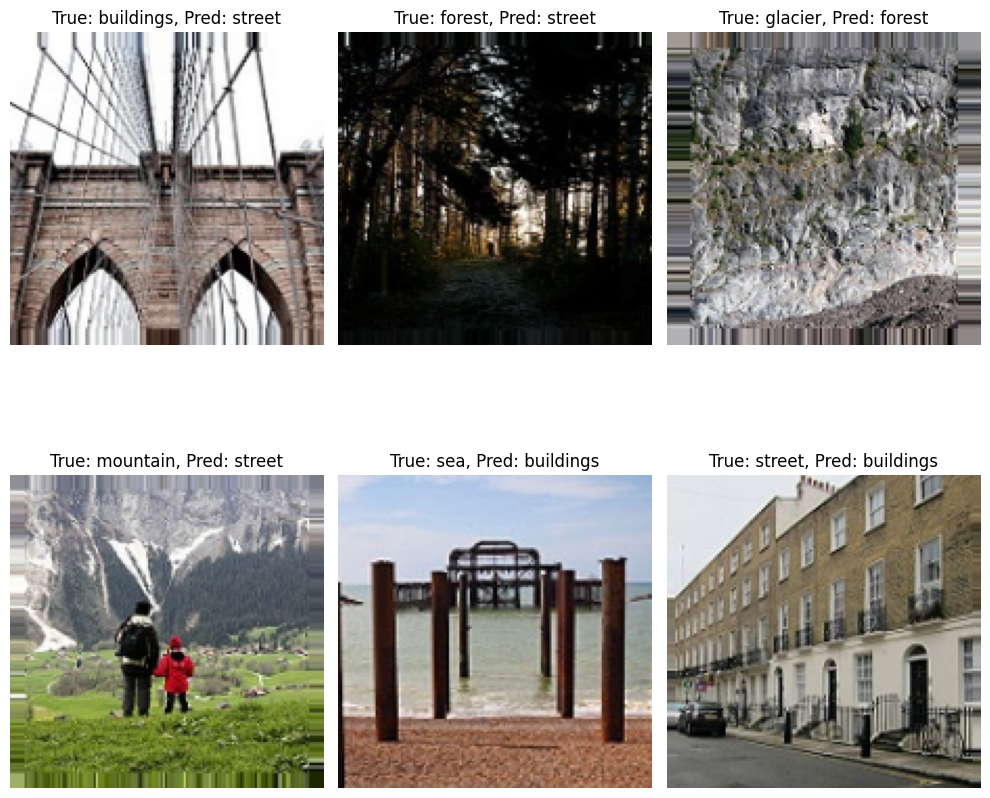

In [207]:
plot_worst_classified_examples(predictions)

# 2. Fine-tune InceptionV3

In [66]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(weights='imagenet', include_top=False)

In [67]:
x2 = base_model2.output
x2 = GlobalAvgPool2D()(x2)
x2 = Dense(1024, activation='relu')(x2)
predictions2 = Dense(num_classes, activation='softmax')(x2)

In [68]:
model2 = Model(inputs=base_model2.input, outputs=predictions2)

In [71]:
for layer in base_model2.layers:
    layer.trainable = False

In [73]:
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, None,      │      9,216 │ activation_188[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, None,      │     18,432 │ activation_189[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, None,      │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_8[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, None,      │    138,240 │ activation_191[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, None,      │          0 │ batch_normalizat

 Total params: 23,907,110 (91.20 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [74]:
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
  2/176 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.1719 - loss: 3.0085 

W0000 00:00:1712597270.749750      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


159/176 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - accuracy: 0.7350 - loss: 1.0833

W0000 00:00:1712597335.409541      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7435 - loss: 1.0373

W0000 00:00:1712597345.803165      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 538ms/step - accuracy: 0.7445 - loss: 1.0321 - val_accuracy: 0.8759 - val_loss: 0.3493
Epoch 2/30


W0000 00:00:1712597364.925718      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 434ms/step - accuracy: 0.8791 - loss: 0.3296 - val_accuracy: 0.8598 - val_loss: 0.3952
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 431ms/step - accuracy: 0.8927 - loss: 0.2867 - val_accuracy: 0.8795 - val_loss: 0.3634
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 431ms/step - accuracy: 0.9108 - loss: 0.2481 - val_accuracy: 0.8891 - val_loss: 0.3164
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 432ms/step - accuracy: 0.9059 - loss: 0.2477 - val_accuracy: 0.8787 - val_loss: 0.3316
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 431ms/step - accuracy: 0.9125 - loss: 0.2346 - val_accuracy: 0.8984 - val_loss: 0.3096
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 430ms/step - accuracy: 0.9131 - loss: 0.2189 - val_accuracy: 0.8820 - val_loss: 0.3375
Epoch 9/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 432ms/step - accuracy: 0.9176 - loss: 0.2137 - val_accuracy: 0.8955 - val_loss: 0.3359
Epoch 10/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 433ms/step - accuracy: 0.9292 - loss: 0.1923 - va

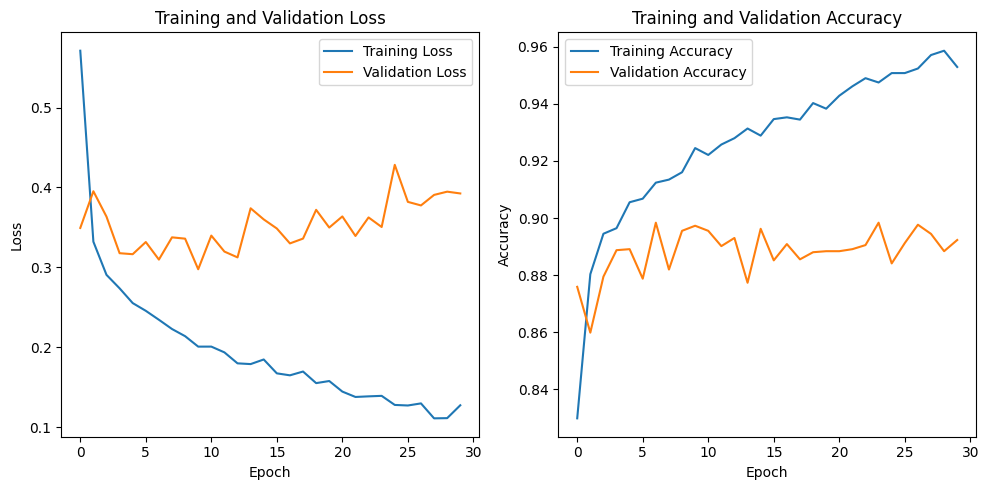

In [76]:
plot_learning_curve(history2)

In [77]:
evaluate_on_test_dataset(model2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step - accuracy: 0.8851 - loss: 0.4083
Test Loss: 0.4130009114742279
Test Accuracy: 0.8826666474342346


W0000 00:00:1712599668.347777      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [180]:
predictions2 = model2.predict(test_generator)

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step


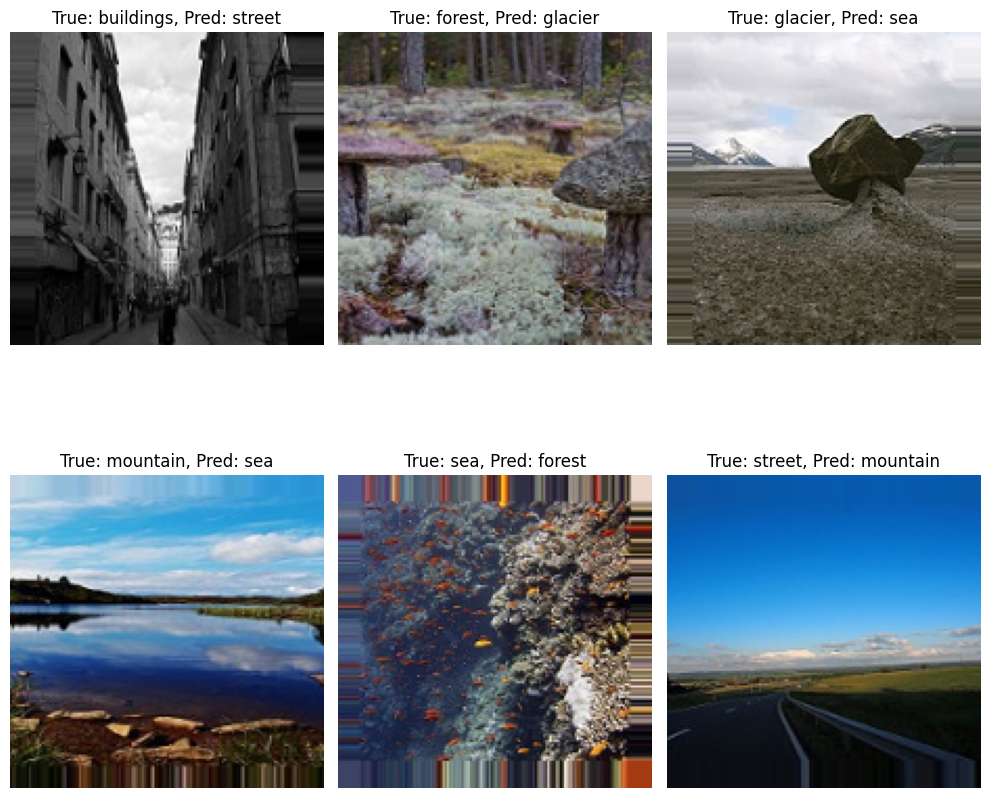

In [196]:
plot_worst_classified_examples(predictions2)